In [1]:
import networkx as nx
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Digg = nx.read_edgelist("datasets/digg-friends", create_using=nx.DiGraph, data=(('weight', int),('sec', int),))

In [3]:
Ubuntu = nx.read_edgelist("datasets/askubuntu-c2q.txt", create_using=nx.DiGraph, data=(('sec', int),))

In [4]:
# Math = nx.read_edgelist("datasets/mathoverflow-a2q.txt", create_using=nx.DiGraph, data=(('sec', int),))

In [5]:
Msg = nx.read_edgelist("datasets/CollegeMsg.txt", create_using=nx.DiGraph, data=(('sec', int),))

In [6]:
patterns_Msg = nx.get_eight_patterns_df(Msg)

In [8]:
# patterns_Ubuntu = nx.get_eight_patterns_df(Ubuntu)

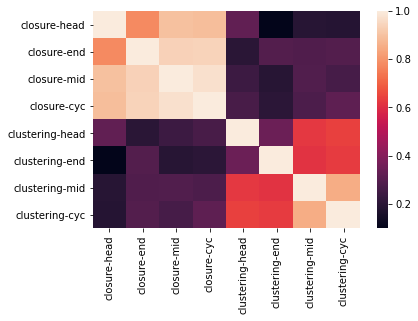

In [9]:
sns.heatmap(patterns_Msg.corr())

In [ ]:
nx.head_closure(Msg, nodes = ['1', '2', '3', '4'])

In [ ]:
print(nx.average_head_closure(Msg))
print(nx.average_end_closure(Msg))
print(nx.average_mid_closure(Msg))
print(nx.average_cyc_closure(Msg))

In [ ]:
nx.average_four_patterns(Msg, closure=False)

In [ ]:
nx.link_pred_sample_app(Ubuntu, repeat=1)

In [ ]:
nx.direction_pred_app(G, method = 'mixed', repeat=10, b = 100)

In [ ]:
old_pct = 0.5
e_all = list(G.edges(data=True))
e_all = sorted(e_all, key=lambda t: t[2].get('sec'))    #for networks with timestamps
k = round(len(e_all) * old_pct)

e_old = e_all[: k]
e_new = e_all[k:]
G_old = nx.DiGraph()
G_old.add_edges_from(e_old)

In [ ]:
random.shuffle(e_new)
e_new_sample = e_new[: 1000]
e_target = get_e_possible_to_predict(e_new_sample, G_old)  # ground truth
target_num_links = len(e_target)
print("target number of links: %d" % target_num_links)

G_new = nx.DiGraph()
G_new.add_edges_from(e_target)  # ground truth
G_new_undirected = G_new.to_undirected()

In [ ]:
dict_ce = nx.closure(G_old, G_new_undirected.nodes())

In [ ]:
for e in G_new_undirected.edges():
    print("closure: %.3f; degree: %d\n" % (dict_ce[e[0]][1], G_old.out_degree(e[0])))

In [ ]:
# using degree score
dict_e_with_di_score = get_direction_score(G_new_undirected, G_old)

In [ ]:
dict_e_with_zero = {k:v for k,v in dict_e_with_di_score.items() if v[0]==0}   # dict containg edges with zero direction score
ordered_list_of_zero_dict = [(k, v) for k, v in sorted(dict_e_with_zero.items(), key=lambda item: item[1][1], reverse=True)]  #sort according to L2R + R2L in descending order
len_zero = len(ordered_list_of_zero_dict)

res_G_directed = nx.DiGraph()  # what to return

for k, v in dict_e_with_di_score.items():
    if v[0] > 0:
        res_G_directed.add_edge(k[0], k[1])
    if v[0] < 0:
        res_G_directed.add_edge(k[1], k[0])
current_num_link = res_G_directed.number_of_edges()

In [ ]:
index = 0
while current_num_link < target_num_links and index < len_zero:
    e_key = ordered_list_of_zero_dict[index][0]
    res_G_directed.add_edge(e_key[0], e_key[1])
    current_num_link += 1
    if current_num_link == target_num_links:
        break
    res_G_directed.add_edge(e_key[1], e_key[0])
    current_num_link += 1
    index += 1

In [ ]:
if current_num_link < target_num_links:
    dict_abs_score = dict()  # used to sort, only contain edges with non_zero score
    for key in dict_e_with_di_score:
        if dict_e_with_di_score[key][0] != 0:
            dict_abs_score[key] = abs(dict_e_with_di_score[key][0])

    ordered_list_of_abs_dict = [(k, v) for k, v in
                                sorted(dict_abs_score.items(), key=lambda item: item[1])]  # in ascending order

In [ ]:
length = len(ordered_list_of_abs_dict)
index = 0  # initialised at the begining of list

while current_num_link < target_num_links and index < length:
    e_key = ordered_list_of_abs_dict[index][0]
    e_value = dict_e_with_di_score[e_key][0]

    if e_value > 0:
        res_G_directed.add_edge(e_key[1], e_key[0])
        current_num_link += 1
    else:
        res_G_directed.add_edge(e_key[0], e_key[1])
        current_num_link += 1
    index += 1

In [ ]:
current_num_link

In [ ]:
#degree direction result!
numerator = 0
true_list_degree = []
for e in res_G_directed.edges():

    if res_G_directed.has_edge(e[0], e[1]) and G_new.has_edge(e[0], e[1]):
        numerator += 1
        true_list_degree.append(e)

In [ ]:
# closure direction result!
numerator = 0
true_list_closure = []
for e in res_G_directed.edges():

    if res_G_directed.has_edge(e[0], e[1]) and G_new.has_edge(e[0], e[1]):
        numerator += 1
        true_list_closure.append(e)

In [ ]:
common_true = [e for e in true_list_closure if e in true_list_degree]

In [ ]:
print("correct predicion with closure score: %d" % len(true_list_closure))
print("correct predicion with degree score: %d" % len(true_list_degree))
print("intersection of above two %d:" %len(common_true))

In [ ]:
def get_e_possible_to_predict(e_new, G_old):
    e_possible_to_predict = []
    old_node_list = list(G_old.nodes())

    for e in e_new:
        if (e[0] in old_node_list) and (e[1] in old_node_list):
            e_possible_to_predict.append(e)
    return e_possible_to_predict


#get direction score for interested edges, using src-clo and tgt-clo
def get_direction_score(G_new_sample, G_old):
    dict_e_with_di_score = dict()

    dict_ce = nx.closure(G_old, G_new_sample.nodes())   #only for nodes exist in G_new

    for e in G_new_sample.edges():
        left_src = dict_ce[e[0]][1]
        left_tgt = dict_ce[e[0]][2]
        right_src = dict_ce[e[1]][1]
        right_tgt = dict_ce[e[1]][2]
        L2R = left_src + right_tgt
        R2L = right_src + left_tgt

        dict_e_with_di_score[e] = [L2R - R2L, L2R + R2L]

    return dict_e_with_di_score


#get direction score for interested edges, using out_degree and in_degree
def get_direction_score_two(G_new_sample, G_old):
    dict_e_with_di_score = dict()

    for e in G_new_sample.edges():
        left_src = G_old.out_degree(e[0])
        left_tgt = G_old.in_degree(e[0])
        right_src = G_old.out_degree(e[1])
        right_tgt = G_old.in_degree(e[1])
        L2R = left_src + right_tgt
        R2L = right_src + left_tgt

        dict_e_with_di_score[e] = [L2R - R2L, L2R + R2L]

    return dict_e_with_di_score

In [ ]:
Google = nx.read_edgelist("datasets/google.txt", create_using=nx.DiGraph)

In [ ]:
nx.link_pred_sample_app(Google, repeat=2, sample_time=10)

In [ ]:
with open ("Ubuntu_info.txt", 'w') as f:
    for i in aa:
        f.write("%.4f\n" % i)

In [ ]:
Stack = nx.read_edgelist("datasets/stackoverflow-a2q.txt", create_using=nx.DiGraph, data=(('sec', int),))

In [ ]:
Flickr = nx.read_edgelist("datasets/Flickr.txt", create_using=nx.DiGraph, data=(('weight', int),('sec', int),))

In [ ]:
Epi = nx.read_edgelist("datasets/epinions.txt", create_using=nx.DiGraph, data=(('weight', int),('sec', int),))
Alpha = nx.read_edgelist("datasets/bitcoinalpha.csv", delimiter = ',', create_using=nx.DiGraph, data=(('weight', int),('sec', int),))
OTC = nx.read_edgelist("datasets/bitcoinotc.csv", delimiter = ',', create_using=nx.DiGraph, data=(('weight', int),('sec', float),))

In [ ]:
Wiki = nx.read_edgelist("datasets/wiki-Vote.txt", create_using=nx.DiGraph)
Msg = nx.read_edgelist("datasets/CollegeMsg.txt", create_using=nx.DiGraph, data=(('sec', int),))
Blogs = nx.read_edgelist("datasets/Blogs.txt", create_using=nx.DiGraph)

In [ ]:
nx.link_pred_sample_app(Wiki, repeat=5, sample_time=5)

In [ ]:
nx.link_pred_sample_app(Dame, repeat=2, sample_time=2)

In [ ]:
Ama = nx.read_edgelist("datasets/amazon.txt", create_using=nx.DiGraph)

In [ ]:
Cit = nx.read_edgelist("datasets/cit-Patents.txt", create_using=nx.DiGraph)

In [ ]:
Dame = nx.read_edgelist("datasets/NotreDame.txt", create_using=nx.DiGraph)
Ado = nx.read_edgelist("datasets/Adohealth.txt", create_using=nx.DiGraph, data=(('weight', int),))
Alpha = nx.read_edgelist("datasets/bitcoinalpha.csv", delimiter = ',', create_using=nx.DiGraph, data=(('weight', int),('sec', int),))

In [ ]:
Toy = nx.read_edgelist("datasets/toy.csv", delimiter = ',', create_using=nx.DiGraph, data=(('weight', int),))
Toy_signed = nx.read_edgelist("datasets/toy_sign.txt", delimiter = ',', create_using=nx.DiGraph, data=(('weight', int),))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon

fig, (ax1, ax2, ax3) = plt.subplots(3)

bars = ax2.bar(range(1, 5), range(1, 5), color='yellow', ecolor='black') + ax2.bar(range(1, 5), [6] * 4, bottom=range(1, 5),
            color='green', ecolor='black')
ax2.set_xticks([1.5, 2.5, 3.5, 4.5])

patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)